In [1]:
%pylab inline
import pandas as pd
import docx
from docx.shared import Pt
import warnings 
warnings.filterwarnings("ignore")
from collections import defaultdict
from joblib import Parallel, delayed
import tqdm

#MY SETUP FOR MATPLOTLIB
def setup_mpl():
    mpl.rc('font', size=7)
    mpl.rcParams['legend.fontsize'] = 'small'
    mpl.rcParams['legend.fontsize'] = 'small'
    mpl.rcParams['xtick.labelsize'] = 'small'
    mpl.rcParams['ytick.labelsize'] = 'small'
    mpl.rcParams['font.family']='Helvetica 55 Roman'
    mpl.rcParams['lines.linewidth'] = 1
    mpl.rcParams['xtick.major.width'] = 2/3.
    mpl.rcParams['ytick.major.width'] = 2/3.
    mpl.rcParams['xtick.minor.width'] = 2/3.
    mpl.rcParams['ytick.minor.width'] = 2/3.
    mpl.rcParams['xtick.major.size'] = 3
    mpl.rcParams['ytick.major.size'] = 3
    mpl.rcParams['xtick.minor.size'] = 1.5
    mpl.rcParams['ytick.minor.size'] = 1.5
    mpl.rcParams['axes.linewidth'] = 2/3.
    mpl.rcParams['ytick.direction'] = 'in'
    mpl.rcParams['xtick.direction'] = 'in'
    mpl.rcParams['xtick.top']=True
    mpl.rcParams['ytick.right']=True
    mpl.rcParams['mathtext.default']='regular'
    mpl.rcParams['xtick.major.pad']='2.3'
    mpl.rcParams['ytick.major.pad']='2.3'
    mpl.rcParams['axes.labelpad']= 2
    mpl.rcParams['figure.dpi'] = 400
    mpl.rcParams['svg.fonttype'] = "none"
    alpha = 0.6
    to_rgba = mpl.colors.ColorConverter().to_rgba
setup_mpl()

Populating the interactive namespace from numpy and matplotlib


In [2]:
data_size = pd.read_pickle("../outputs/Figure1/data_size.pkl")

Text(0, 0.5, 'fraction of users')

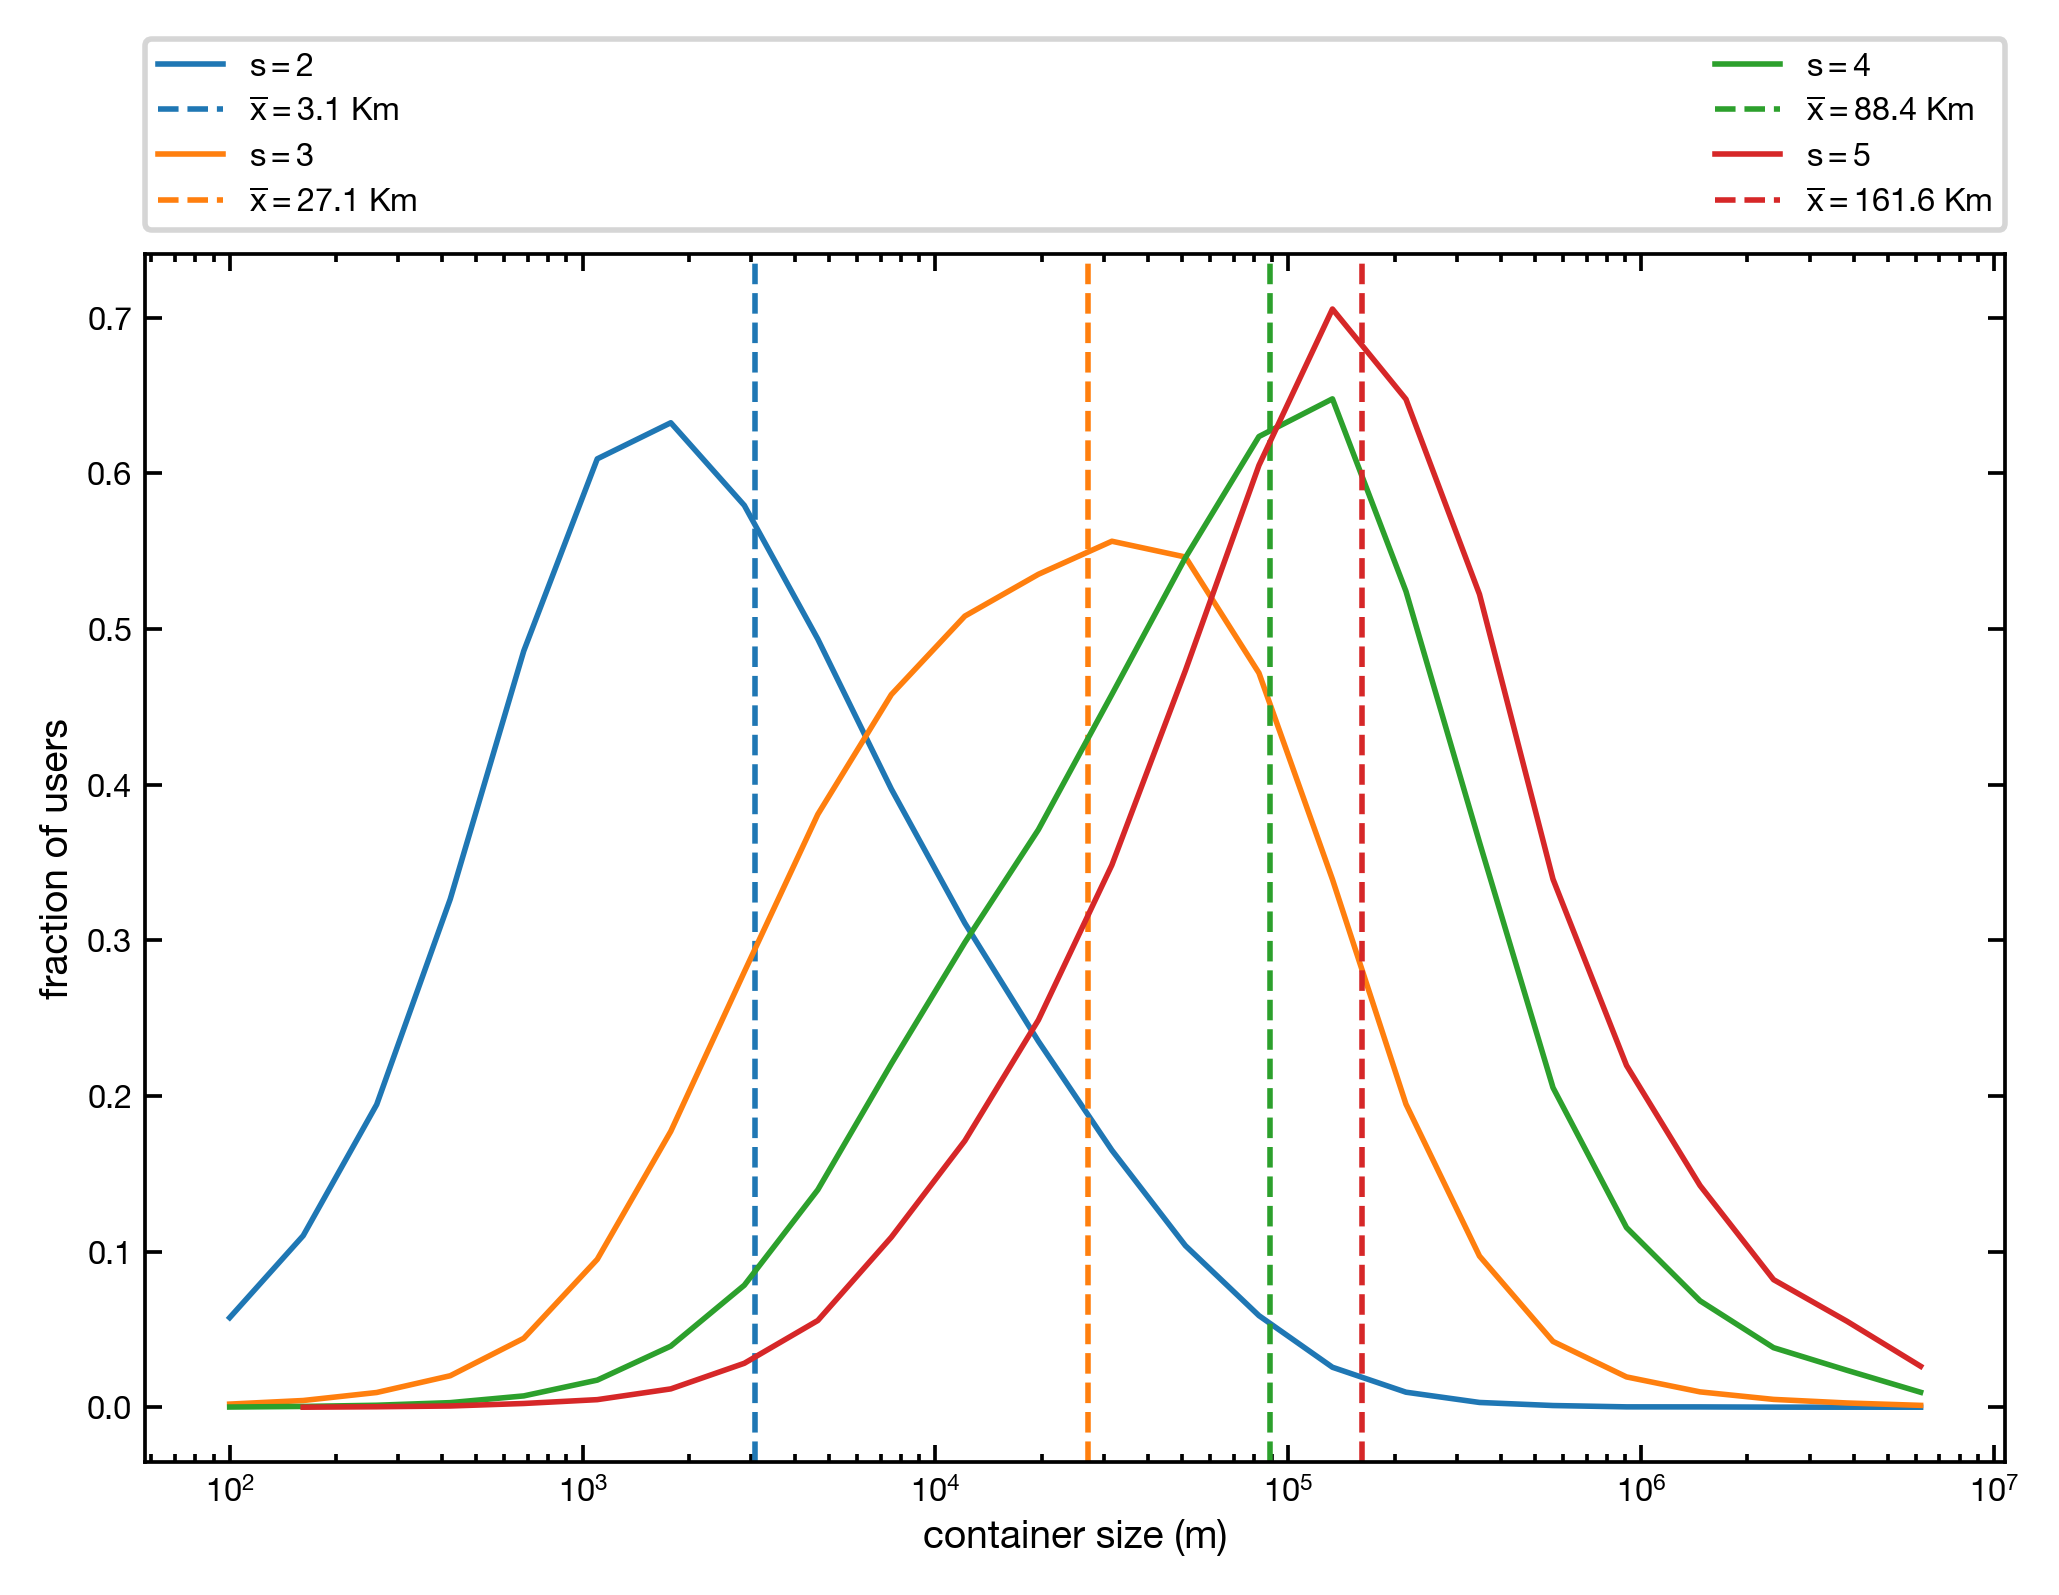

In [34]:
fig, ax2 = plt.subplots()

ys = [[10**i for i in np.linspace(2,7,25)]]
for n, group in data_size.groupby('level'):
    values = np.log10(group['size'].values)
    
    hist, edges = np.histogram(values, bins = np.linspace(2,7,25), density = True)
    x,y = zip(*[(k,k2) for (k,k2) in zip(edges,hist) if k2>0])
    ax2.plot([10**i for i in x], y, label =r'$s={}$'.format(n), color = 'C{}'.format(n-2))    
    ax2.axvline(10**np.mean(values), color = 'C{}'.format(n-2),label = r'$\overline{x}=%.1f$ Km'%(10**np.mean(values)/1000), ls = '--')
    ys.append(hist)
#Axies and legend
ax2.set_xscale('log')
ax2.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,ncol=2, mode="expand", borderaxespad=0.)
ax2.set_xlabel('container size (m)')
ax2.set_ylabel('fraction of users')



In [38]:
pd.DataFrame(ys,index = ['x','level2_size','level3_size','level4_size','level5_size']).T.to_csv("../outputs/Figure1/source_data1.csv",index = False)

In [39]:
data_time = pd.read_pickle("../outputs/Figure1/data_time.pkl")

Text(-0.1, 1.1, 'C')

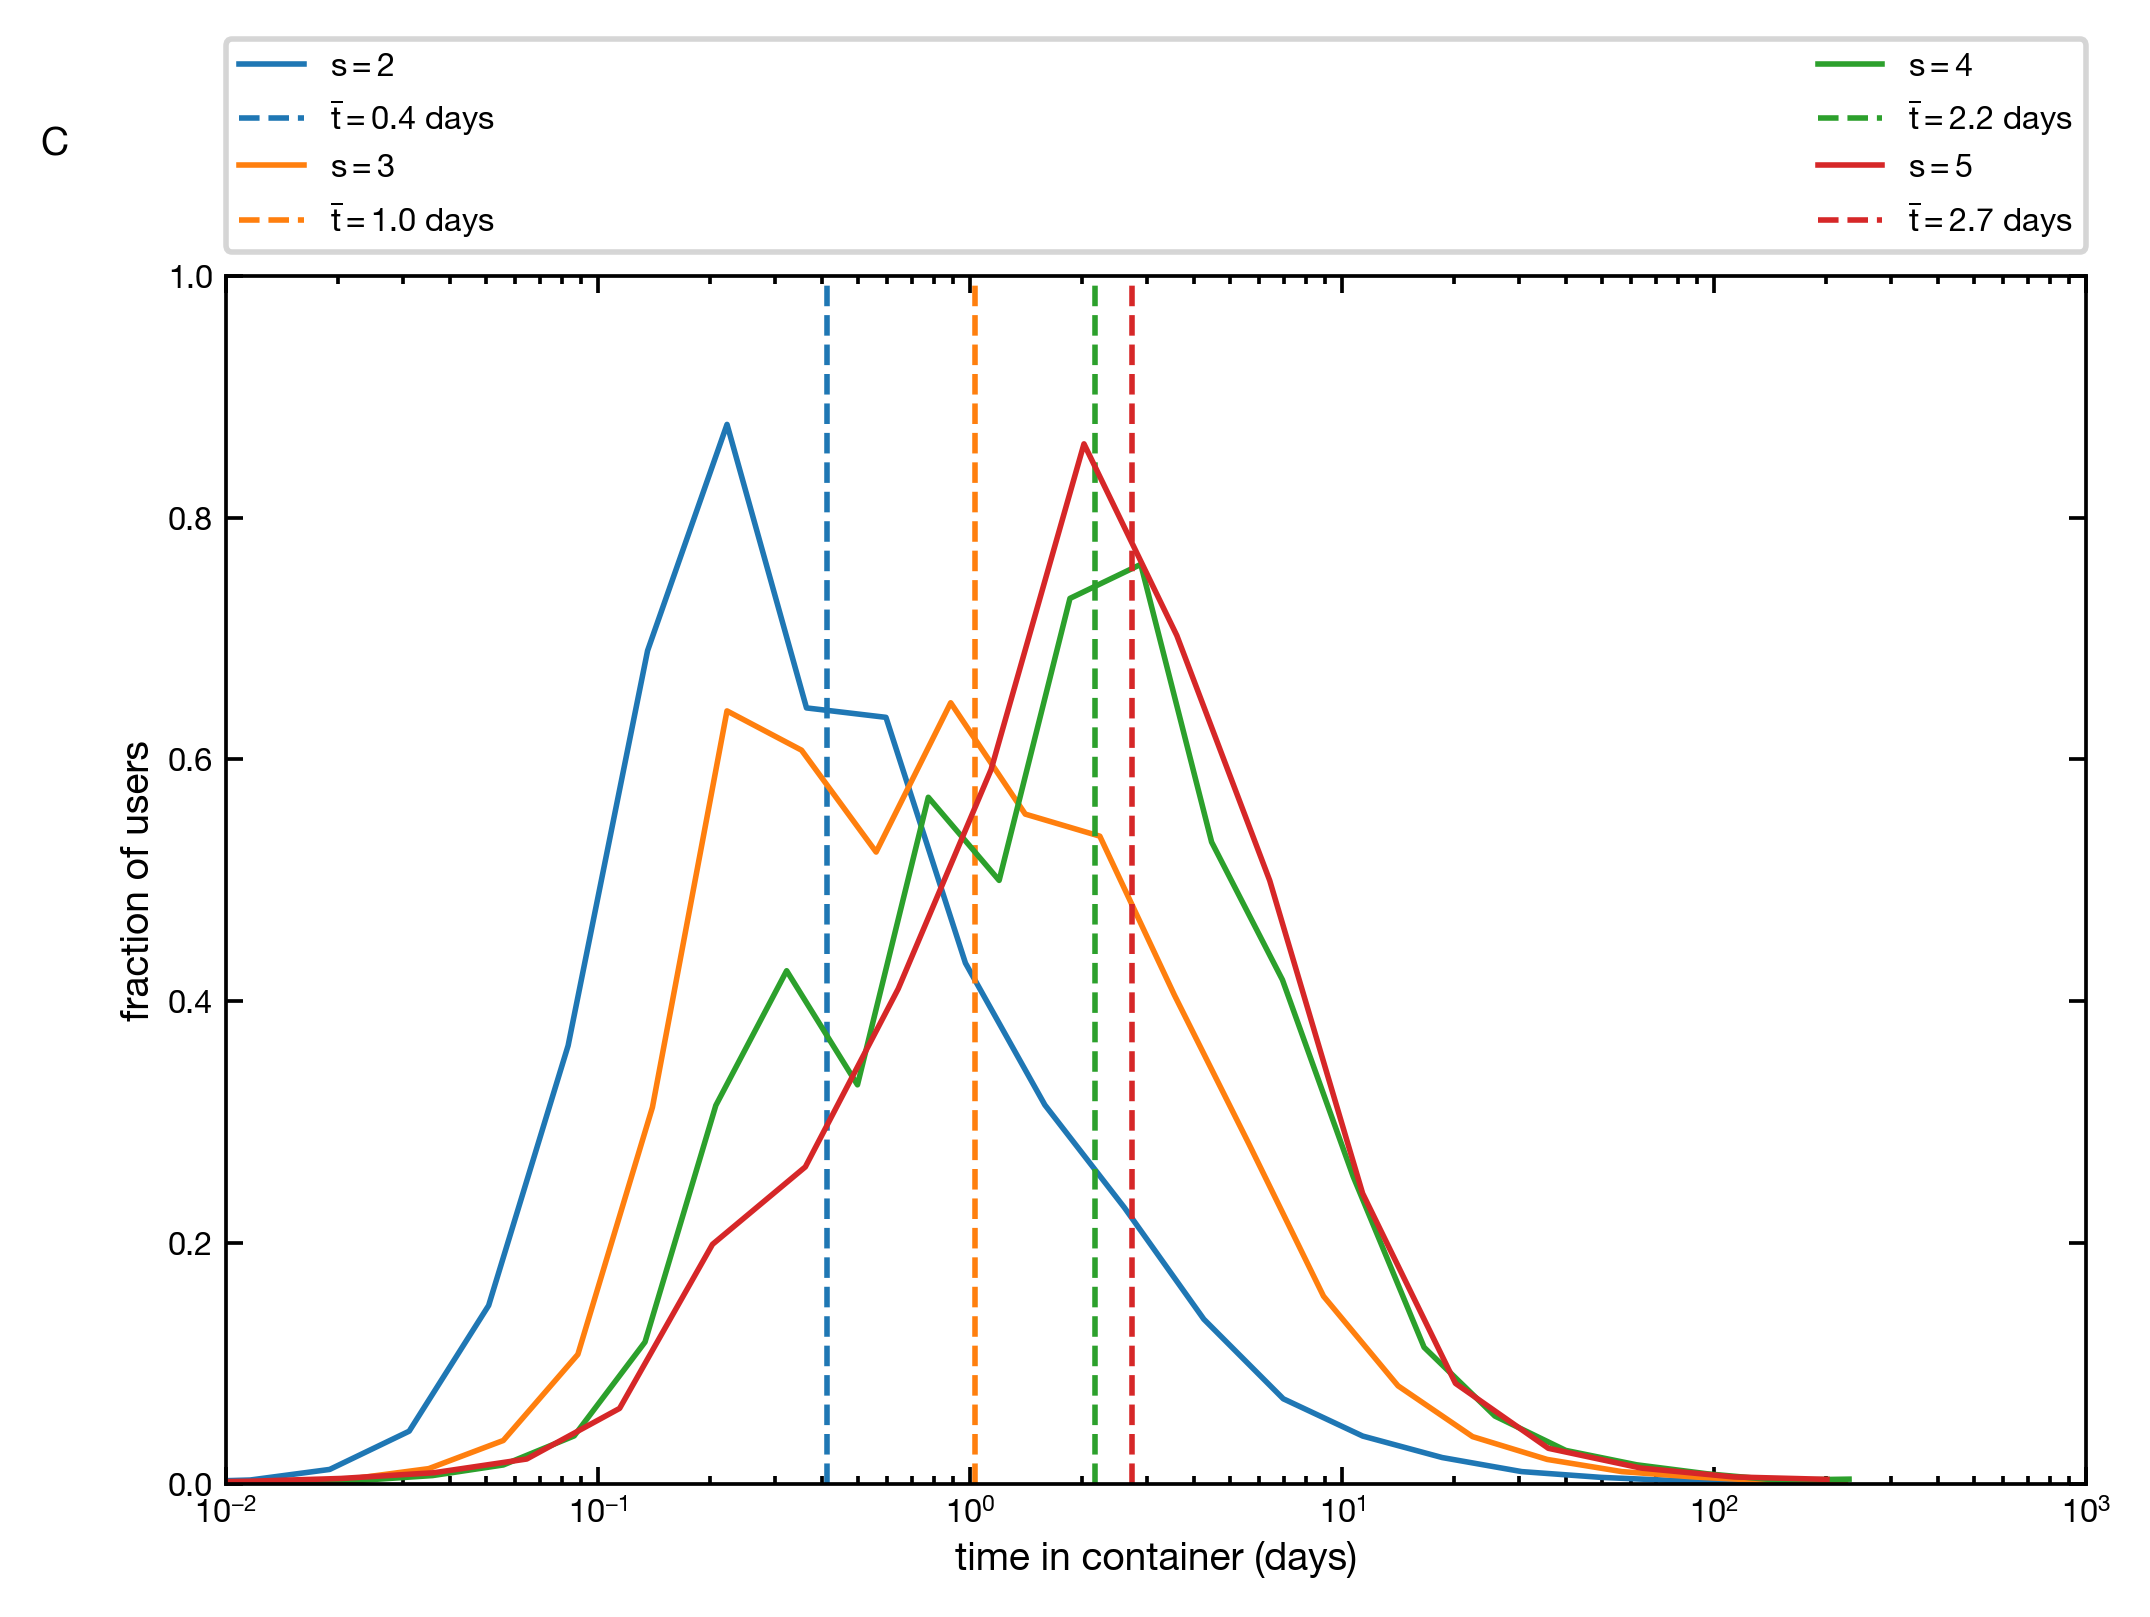

In [40]:
fig, ax3 = plt.subplots()
ys = []
for scale, group in data_time[data_time.trip_scale>1].groupby('trip_scale'):
    values = np.log10([i for i in group['inter_time']/(60*60*24) if i>0 and i/(60*60*24)<100])
    hist,edges = np.histogram(values, bins = 30,density = True)
    ax3.plot([10**i for i in edges[:-1]],hist, color = 'C{}'.format(scale-2), label = r'$s={}$'.format(scale))
    ax3.axvline(10**np.median(values), color = 'C{}'.format(scale-2),label = r'$\overline{t}=%.1f$ days'%(10**np.median(values)), ls = '--')
    ys.append([10**i for i in edges[:-1]])
    ys.append(hist)
ax3.set_xscale('log')
ax3.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
              ncol=2, mode="expand", borderaxespad=0.)
ax3.set_ylabel('fraction of users')
ax3.set_xlabel('time in container (days)')
ax3.set_xlim(0.01,1000)
ax3.set_ylim(0,1)
ax3.text(-0.1, 1.1, 'C', transform=ax3.transAxes)

In [42]:
pd.DataFrame(ys,index = ['x_2','level2_time','x_3','level_3_time','x_4','level_4_time','x_5','level_5_time',]).T.to_csv("../outputs/Figure1/source_data2.csv",index = False)

# Likelihood of different distributions

In [173]:
def loglikelihood_ratio(loglikelihoods1, loglikelihoods2,
        nested=False, normalized_ratio=False):
    """
    Calculates a loglikelihood ratio and the p-value for testing which of two
    probability distributions is more likely to have created a set of
    observations.

    Parameters
    ----------
    loglikelihoods1 : list or array
        The logarithms of the likelihoods of each observation, calculated from
        a particular probability distribution.
    loglikelihoods2 : list or array
        The logarithms of the likelihoods of each observation, calculated from
        a particular probability distribution.
    nested : bool, optional
        Whether one of the two probability distributions that generated the
        likelihoods is a nested version of the other. False by default.
    normalized_ratio : bool, optional
        Whether to return the loglikelihood ratio, R, or the normalized
        ratio R/sqrt(n*variance)

    Returns
    -------
    R : float
        The loglikelihood ratio of the two sets of likelihoods. If positive,
        the first set of likelihoods is more likely (and so the probability
        distribution that produced them is a better fit to the data). If
        negative, the reverse is true.
    p : float
        The significance of the sign of R. If below a critical value
        (typically .05) the sign of R is taken to be significant. If above the
        critical value the sign of R is taken to be due to statistical
        fluctuations.
    """
    from numpy import sqrt
    from scipy.special import erfc

    n = float(len(loglikelihoods1))

    if n==0:
        R = 0
        p = 1
        return R, p
    from numpy import asarray
    loglikelihoods1 = asarray(loglikelihoods1)
    loglikelihoods2 = asarray(loglikelihoods2)

    #Clean for extreme values, if any
    from numpy import inf, log
    from sys import float_info
    min_val = log(10**float_info.min_10_exp)
    loglikelihoods1[loglikelihoods1==-inf] = min_val
    loglikelihoods2[loglikelihoods2==-inf] = min_val

    R = sum(loglikelihoods1-loglikelihoods2)

    from numpy import mean
    mean_diff = mean(loglikelihoods1)-mean(loglikelihoods2)
    variance = sum(
            ( (loglikelihoods1-loglikelihoods2) - mean_diff)**2
            )/n

    if nested:
        from scipy.stats import chi2
        p = 1 - chi2.cdf(abs(2*R), 1)
    else:
        p = erfc( abs(R) / sqrt(2*n*variance))

    if normalized_ratio:
        R = R/sqrt(n*variance)

    return R, p

def find_best_fit(func,v):
    '''
    Find the best initial guess for fitting distribution in scipy.
    '''
    print(func)
    if func.shapes: 
        n=len(func.shapes)
    else:
        n = 0
    
    
    def fit_once(n):
        in_guesses = [np.random.rand()*(5*np.log10(max(v))) for i in range(2+n)]
        par = func.fit(v,*in_guesses[:-2], loc = in_guesses[-1],scale=in_guesses[-2])
        l = sum(func.logpdf(v,*par))
        return l,par
        
        
    
    res = Parallel(n_jobs=10)(delayed(fit_once)(n) for _ in tqdm.tqdm(range(50)))
    l,par = sorted(res,key=lambda x:x[0])[-1]

    return par


In [156]:
from scipy import stats
##LISTS OF FUNCTIONS 
names = ['lognormal','truncated power-law','powerlaw',"log-logistic","log gamma","log laplace","log-weibull"]
funcs = [stats.lognorm, 
         stats.gamma,
         stats.powerlaw, 
         stats.fisk,
         stats.loggamma,
         stats.loglaplace,
         stats.gumbel_r]

In [157]:
def significance(p):
    if p<0.001:
        return "***"
    elif p<0.01:
        return "**"
    elif p<0.05:
        return "*"
    else:
        return "(ns)"


In [158]:
def compute_loglikelihood_ratios(values,
                                 funcs,
                                 names,
                                 compare_to=0):
    parameters = [find_best_fit(func, v) for func in funcs]
    likelihoods = [func.logpdf(v, *parameters[n3]) for n3,func in enumerate(funcs) ]
    ratios = [loglikelihood_ratio(likelihoods[compare_to],likelihoods[n]) for n in range(len(funcs))]
    ratios = [str(int(R))+significance(p) for R,p in ratios]
    return dict(zip(names,ratios)),parameters

In [ ]:
##sizes

ratios = dict()
parameters = dict()
for level in range(2,6):
    v = data_size[data_size['level']==level]['size'].values
    res = compute_loglikelihood_ratios(values,
                                                 funcs,
                                                 ["R lognormal/{}".format(i) for i in names])
    ratios[("D1","level={}".format(level))] = res[0]
    parameters[level] = res[1]

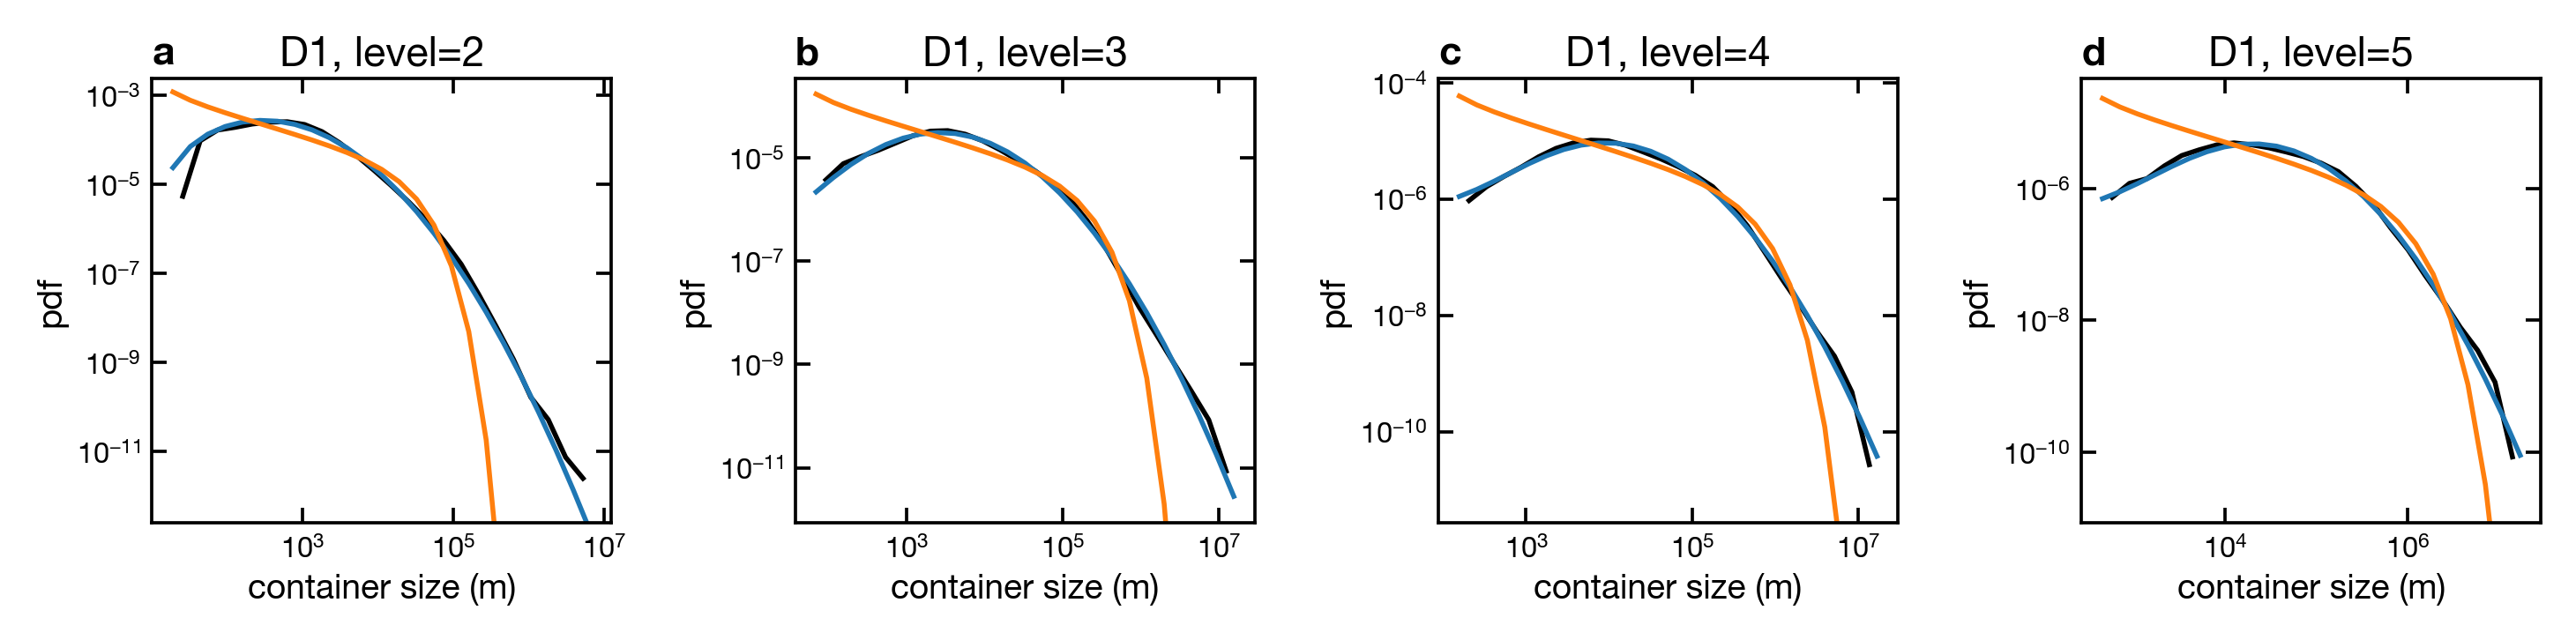

In [306]:
###PLOT
fig, ax = plt.subplots(1,4, figsize = (3.60236*2,2))
plt.subplots_adjust(bottom = 0.25, wspace=0.4,left=0.05,right=0.99)

y1 = ax[0].get_position().get_points()[-1][1]+0.02

for level in range(0,4):
    
    ##VALUES
    v = data_size[data_size['level']==level+2]['size'].values

    
    ##WRITE TITLE
    x1 =  ax[level].get_position().get_points()[0][0]
    x2 = ax[level].get_position().get_points()[1][0]
    ax[level].set_title("D1, level={}".format(level+2),y = y1,x = (x2+x1)/2, transform=fig.transFigure)
    
    
    
    #PLOT HISTOGRAM
    X = np.logspace(np.log10(min(v)*2),np.log10(max(v)),25)
    hist,edges = np.histogram(v,bins = X, density = True)
    x, y = zip(*[(i,j) for (i,j) in zip((edges[:-1]+edges[1:])/2, hist) if j>0])
    ax[level].loglog(x,y, color = 'k',label = 'data')
    
    
    ##FIND PARAMETERS
    aa = [func.pdf(X,*parameters[level][n]) for n, func in enumerate(funcs[:2])]
    for n, i in enumerate(aa):
        ax[level].loglog(X,i,label = names[n])
    ax[level].set_xlabel('container size (m)')
    ax[level].set_ylabel('pdf')
    ymin, ymax = ax[level].get_ylim()
    ax[level].set_ylim(min(y)*0.1,max(aa[1]*2))

        

        
##WRITE LETTERS


y1 = ax[0].get_position().get_points()[-1][1]+0.02

letters = ['a','b','c','d']
positions = [ax[i].get_position().get_points()[0][0] for i in range(4)] 
positions2 = [y1]*(4)
for n,a in enumerate(ax):
    a.text(positions[n], positions2[n], 
           letters[n], 
           transform=fig.transFigure, 
           fontsize = 8, 
           weight="bold", 
           fontdict={ 'family':'Helvetica 55 Roman'} )
    
largest_x = ax[-1].get_position().get_points()[1][0]



plt.savefig("../outputs/Extended_data/Extended_data_3_a_d.pdf",dpi=600)
plt.savefig("../outputs/Extended_data/Extended_data_3_a_d.svg",dpi=600)


In [153]:
#Print to file
table = pd.DataFrame(ratios).loc[["R lognormal/{}".format(i) for i in names[1:]]]


doc = docx.Document()
t = doc.add_table(table.shape[0]+1,table.shape[1])
for j in range(table.shape[-1]):
    t.cell(0,j).text = table.columns[j]

for i in range(table.shape[0]):
    for j in range(table.shape[-1]):
        t.cell(i+1,j).text = str(table.values[i,j])
for row in t.rows:
    for cell in row.cells:
        paragraphs = cell.paragraphs
        for paragraph in paragraphs:
            for run in paragraph.runs:
                font = run.font 
                font.name = 'Helvetica 55 Roman'
                font.size = Pt(7)
doc.save("../outputs/Extended_data/Extended_data_2_D1.docx")

In [298]:
##TIME
import warnings 
warnings.filterwarnings("ignore")
from collections import defaultdict
ratios_time = dict()
for level in range(2,6):
    v = data_time[data_time['trip_scale']==level]['inter_time'].values
    ratios_time[("D1","level={}".format(level))] = compute_loglikelihood_ratios(values,
                                                 funcs[:2],
                                                 ["R lognormal/{}".format(i) for i in names[:2]])




  0%|          | 0/50 [00:00<?, ?it/s]


100%|██████████| 50/50 [03:15<00:00,  3.91s/it]

  0%|          | 0/50 [00:00<?, ?it/s]


100%|██████████| 50/50 [01:46<00:00,  2.14s/it]

  0%|          | 0/50 [00:00<?, ?it/s]


100%|██████████| 50/50 [02:44<00:00,  3.29s/it]

  0%|          | 0/50 [00:00<?, ?it/s]


100%|██████████| 50/50 [01:18<00:00,  1.57s/it]

  0%|          | 0/50 [00:00<?, ?it/s]


100%|██████████| 50/50 [01:57<00:00,  2.35s/it]

  0%|          | 0/50 [00:00<?, ?it/s]


100%|██████████| 50/50 [00:53<00:00,  1.06s/it]

  0%|          | 0/50 [00:00<?, ?it/s]


100%|██████████| 50/50 [01:10<00:00,  1.41s/it]

  0%|          | 0/50 [00:00<?, ?it/s]


100%|██████████| 50/50 [00:29<00:00,  1.71it/s]


In [300]:
pd.DataFrame.from_dict(ratios_time,orient='columns')

D1                               
                                   level=2    level=3   level=4   level=5
R lognormal/lognormal                0(ns)      0(ns)     0(ns)     0(ns)
R lognormal/truncated power-law  176821***  104424***  50225***  22965***

In [303]:
#Print to file
table = pd.DataFrame(ratios_time).iloc[1:]


doc = docx.Document()
t = doc.add_table(table.shape[0]+1,table.shape[1])
for j in range(table.shape[-1]):
    t.cell(0,j).text = table.columns[j]

for i in range(table.shape[0]):
    for j in range(table.shape[-1]):
        t.cell(i+1,j).text = str(table.values[i,j])
for row in t.rows:
    for cell in row.cells:
        paragraphs = cell.paragraphs
        for paragraph in paragraphs:
            for run in paragraph.runs:
                font = run.font 
                font.name = 'Helvetica 55 Roman'
                font.size = Pt(7)
doc.save("../outputs/Extended_data/Extended_data_3_D1.docx")

# charachteristics of lognormal

In [310]:
!pip install statsmodels

     |████████████████████████████████| 9.4 MB 3.3 MB/s eta 0:00:01
     |████████████████████████████████| 231 kB 27.8 MB/s eta 0:00:01


In [320]:
import scipy
from uncertainties import ufloat
from uncertainties.umath import exp,pow,log,sqrt


from statsmodels.base.model import GenericLikelihoodModel


class Lognorm(GenericLikelihoodModel):

    def loglike(self, params):
        shape=params[0]
        scale=params[-1]
        return scipy.stats.lognorm.logpdf(self.endog, shape,0,scale).sum()

def median(mu,sigma):
    return exp(mu)
    
def mode(mu,sigma):
    return exp(mu-pow(sigma,2))

def mean(mu,sigma):
    return exp(mu+pow(sigma,2)/2)

def variance(mu,sigma):
    a = (exp(2*mu+pow(sigma,2)))
    b = (exp(pow(sigma,2)) - 1)
    return a*b

def coeff(mu,sigma):
    return sqrt(exp(pow(sigma,2))-1)


values = []

for level in range(0,4):
    
    ##VALUES
    data = data_size[data_size['level']==level+2]['size'].values

    params = scipy.stats.lognorm.fit(data, floc=0)
    shape=params[0]
    scale=params[-1]
    model_res = Lognorm(data).fit(start_params=[shape,scale])
    
    
    expmu = ufloat(model_res.params[1], model_res.bse[1])                          
    mu = log(expmu)
    sigma = ufloat(model_res.params[0], model_res.bse[0])
    
    values.append(['{:%.3f}'.format(mu),
                  '{:%.3f}'.format(sigma),
                  '{:%.3f}'.format(median(mu,sigma)),
                  '{:%.3f}'.format(mode(mu,sigma)),
                  '{:%.3f}'.format(mean(mu,sigma)),
                  '{:%.3f}'.format(sqrt(variance(mu,sigma))),
                  '{:%.3f}'.format(coeff(mu,sigma))]
                 )
    print()

Optimization terminated successfully.
         Current function value: 9.877169
         Iterations: 45
         Function evaluations: 93

Optimization terminated successfully.
         Current function value: 12.046183
         Iterations: 46
         Function evaluations: 100

Optimization terminated successfully.
         Current function value: 13.227360
         Iterations: 52
         Function evaluations: 110

Optimization terminated successfully.
         Current function value: 13.789790
         Iterations: 51
         Function evaluations: 118



In [321]:
d = pd.DataFrame(values,columns = ['\mu','\sigma','median','mode','mean','std','coeff_variation'])
d.index = range(2,6)
d[['\mu','\sigma','median','coeff_variation','mode']]

,\mu,\sigma,median,coeff_variation,mode
2,8.036+/-0.002,1.526+/-0.001,3089.725+/-6.122,3.042+/-0.007,301.376+/-1.420
3,10.206+/-0.002,1.524+/-0.002,27063.671+/-57.991,3.033+/-0.008,2653.315+/-13.508
4,11.390+/-0.002,1.519+/-0.002,88442.027+/-216.841,3.010+/-0.009,8791.227+/-51.085
5,11.993+/-0.003,1.459+/-0.002,161634.666+/-498.335,2.721+/-0.010,19233.077+/-135.963


In [322]:
#Print to file
table = pd.DataFrame(d)

doc = docx.Document()
t = doc.add_table(table.shape[0]+1,table.shape[1])
for j in range(table.shape[-1]):
    t.cell(0,j).text = table.columns[j]

for i in range(table.shape[0]):
    for j in range(table.shape[-1]):
        t.cell(i+1,j).text = str(table.values[i,j])
for row in t.rows:
    for cell in row.cells:
        paragraphs = cell.paragraphs
        for paragraph in paragraphs:
            for run in paragraph.runs:
                font = run.font 
                font.name = 'Helvetica 55 Roman'
                font.size = Pt(7)
doc.save("../outputs/Extended_data/Extended_data_5_D1.docx")